In [1]:
# importing all the libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd

import os
cwd = os.getcwd()

%run ../functions_MCMC

In [2]:
# define variables
data_seed = 1223
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 60
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5, 0.3])
log_Lambda = np.log(Lambda)
Pij = np.array([0.7])

P = np.array([[0.0, 0.0, 1.0],
              [0.0, 0.0, 1.0],
              [0.7, 0.3, 0.0]])
sigma = 50.0
n_param = 7

parameter_names = ['v1', 'v2', 'log(lambda1)', 'log(lambda2)',
                   'log(lambda3)', 'p31', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                       r'log$(\lambda_2)$', r'log$(\lambda_3)$', r'$p_{31}$',
                       r'$\sigma$']

#choose initial covariance matrix for resampling
init_cov_matrix = np.array([np.diag(np.array([0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01]))
                            for _ in range(n_chains)])


correlated = True
up_to_switches = 1
track = True

plots = False
save = True
all_plots = False
plot_posteriors_grid = False
plot_fit = False
plot_fit_median = False

theta_true = list(V) + list(log_Lambda) + list(Pij) + [sigma] #not including values for P for 2x2

In [3]:
#importing the results of the inference for N=200
#these results can be run in the folder T=60 using the jupyter notebook
#run_inference_3-state_N=200
theta_all = []
for param in parameter_names:
    theta_all += [np.array(pd.read_csv("T=60/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
theta_all = np.array(theta_all)

log_pi = np.array(pd.read_csv("T=60/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
theta_best = theta_all[:, np.argmax(log_pi)]

In [4]:
#importing the results of the inference for N=1600
#these results can be run in the folder T=480 using the jupyter notebook
#run_inference_3-state_N=1600
theta_all_more = []
for param in parameter_names:
    theta_all_more += [np.array(pd.read_csv("T=480/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
theta_all_more = np.array(theta_all_more)

log_pi_more = np.array(pd.read_csv("T=480/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
theta_best_more = theta_all_more[:, np.argmax(log_pi_more)]

In [5]:
#obtain all the model parameters
def get_parameters(theta):
    """Obtaining parameters from theta"""
    V = np.array(list(theta[0:2])+[0.0])
    Lambda = np.exp(theta[2:5])
    P = np.array([[0.0, 0.0, 1.0],
                  [0.0, 0.0, 1.0],
                  [theta[-2], 1-theta[-2], 0.0]])
    sigma = 1.0*theta[-1]
    #print(V, Lambda, P, sigma)
    return V, Lambda, P, sigma

dY = get_data_dy(delta_t = delta_t, T = 480, theta = theta_true,
                 get_parameters = get_parameters, seed = 3001, correlated = correlated)
delta_y = dY

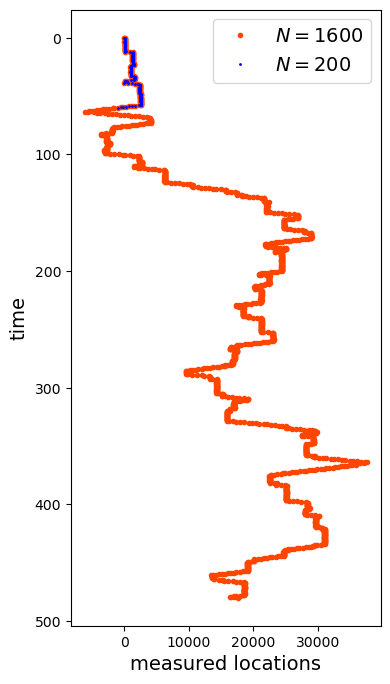

In [6]:
#Figure 3 panel C
N = 1600
rebuild_y = np.zeros(N+1)
for i in range(1, N+1):
    rebuild_y[i] += rebuild_y[i-1] + dY[i-1]
plt.figure(figsize=(4,8))
plt.plot(rebuild_y[:],delta_t*np.arange(0,N+1)[:], '.', color='orangered', alpha=1, label=r'$N=1600$')
plt.plot(rebuild_y[:201],delta_t*np.arange(0,N+1)[:201], '.', color='blue', alpha=1, label=r'$N=200$', markersize=2)
plt.xlabel(r'measured locations', fontsize=14)
plt.ylabel(r'time', fontsize=14)
plt.gca().invert_yaxis()
plt.legend(fontsize=14)
plt.savefig('y_plot_track_0.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()

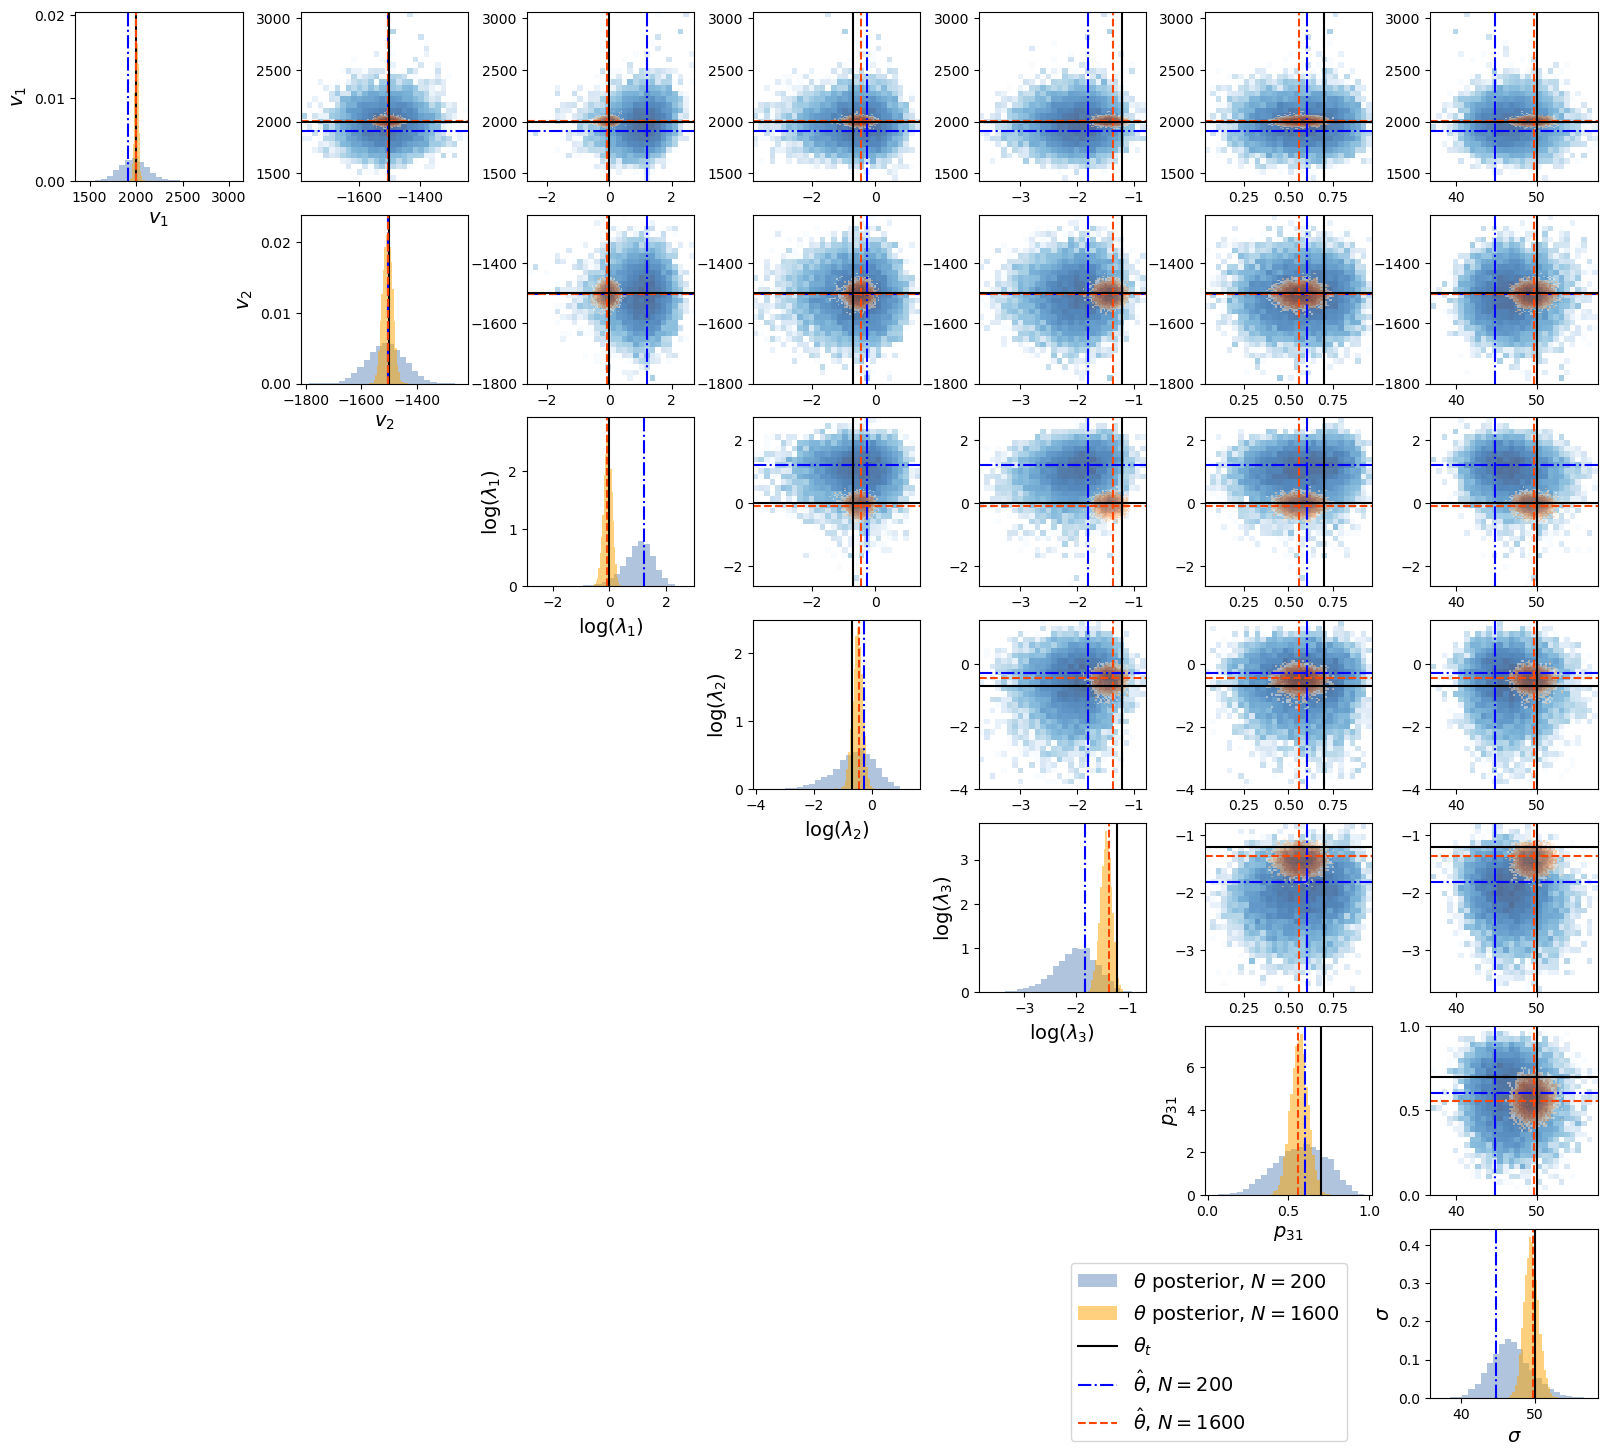

In [7]:
#Figure 3 panel A
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5+2,n_param*2+2+2))
plt.subplots_adjust(wspace=0.35, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)

for i in range(n_param):
    ax[i,i].hist(theta_all[i,:], bins=25, alpha=1.0, density=True,
                 label=r'$\theta$ posterior, $N=200$', color='lightsteelblue')
    ax[i,i].hist(theta_all_more[i,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, $N=1600$', color='orange')
    
    ax[i,i].axvline(theta_true[i], color='black',
                    label=r'$\theta_t$')
    
    best_theta_comp_i = theta_all[i, np.nanargmax(log_pi)]
    ax[i,i].axvline(best_theta_comp_i, linestyle='-.', color='blue',
                    label=r'$\hat\theta$, $N=200$')
    best_theta_comp_i_more = theta_all_more[i, np.nanargmax(log_pi_more)]
    ax[i,i].axvline(best_theta_comp_i_more, linestyle='--', color='orangered',
                    label=r'$\hat\theta$, $N=1600$')
    if i==0 or i==1:
        ax[i,i].set_yticks([0,0.01,0.02])
    elif i==2 or i==3:
        ax[i,i].set_yticks([0,1,2])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all[j,:], theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(theta_all_more[j,:], theta_all_more[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        ax[i,j].hist2d(theta_all[j,:], theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.0, cmap='Blues')
        
        ax[i,j].axvline(theta_all[j, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        ax[i,j].axvline(theta_all_more[j, np.nanargmax(log_pi_more)], linestyle='--', color='orangered')
        
        ax[i,j].axhline(theta_all[i, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        ax[i,j].axhline(theta_all_more[i, np.nanargmax(log_pi_more)], linestyle='--', color='orangered')
        
        ax[i,j].axvline(theta_true[j], color='black')
        ax[i,j].axhline(theta_true[i], color='black')
        if i==1:
            ax[i,j].set_yticks([-1800,-1600,-1400])
        elif i==2:
            ax[i,j].set_yticks([-2,0,2])
        elif i==3:
            ax[i,j].set_yticks([-4,-2,0])
        elif i==4:
            ax[i,j].set_yticks([-3,-2,-1])
        elif i==5:
            ax[i,j].set_yticks([0, 0.5, 1])
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.5, 0.8), loc='upper right', borderaxespad=0, fontsize=14)
plt.savefig("compare_parameters_posteriors.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

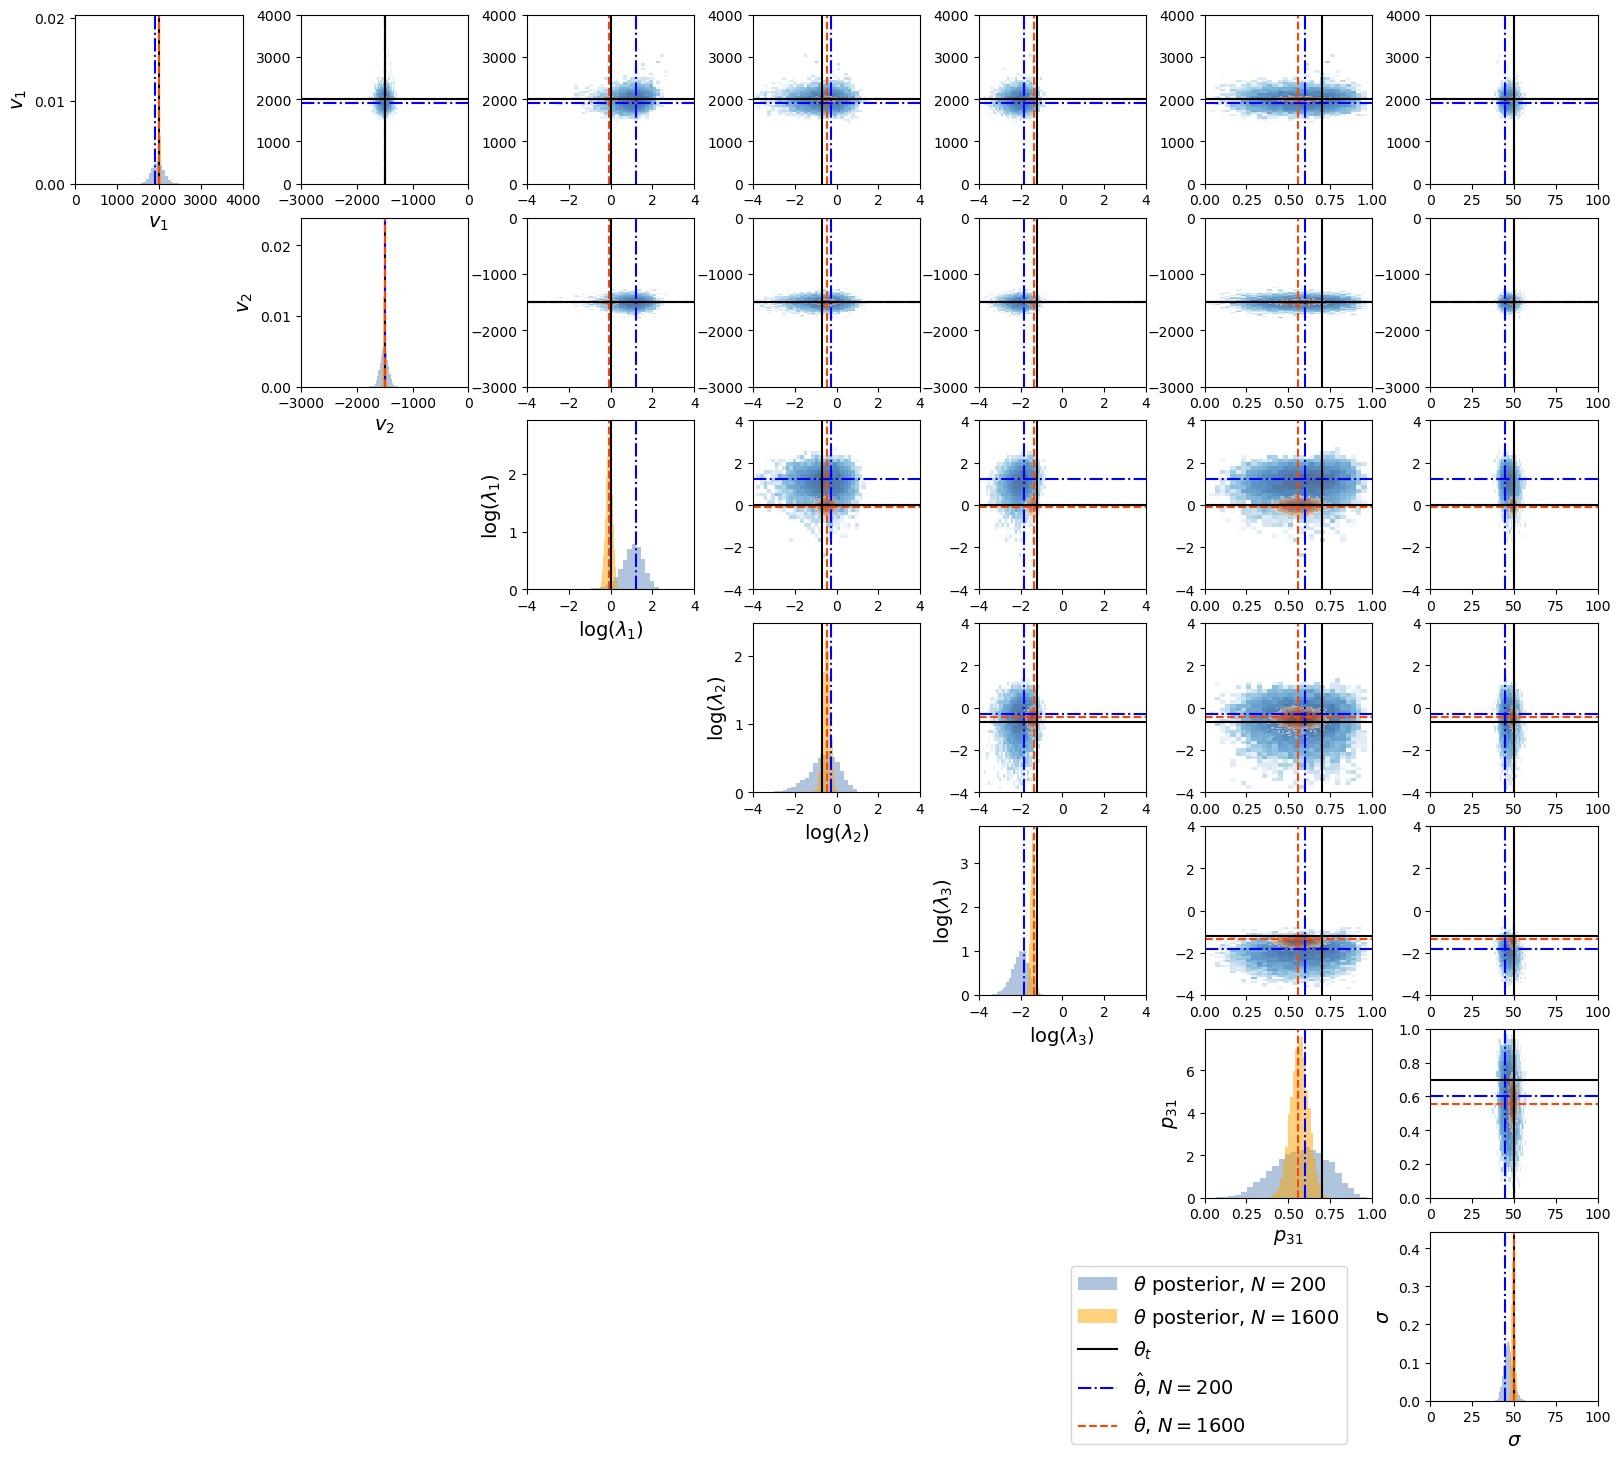

In [8]:
#Supplementary Figure S6
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5+2,n_param*2+2+2))
plt.subplots_adjust(wspace=0.35, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)
    
priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [-4.0, 4.0],
          [0.0, 1.0], [0.0, 2.0*sigma]]

for i in range(n_param):
    ax[i,i].hist(theta_all[i,:], bins=25, alpha=1.0, density=True,
                 label=r'$\theta$ posterior, $N=200$', color='lightsteelblue')
    ax[i,i].hist(theta_all_more[i,:], bins=25, alpha=0.5, density=True,
                 label=r'$\theta$ posterior, $N=1600$', color='orange')
    ax[i,i].axvline(theta_true[i], color='black',
                    label=r'$\theta_t$')
    
    best_theta_comp_i = theta_all[i, np.nanargmax(log_pi)]
    ax[i,i].axvline(best_theta_comp_i, linestyle='-.', color='blue',
                    label=r'$\hat\theta$, $N=200$')
    best_theta_comp_i_more = theta_all_more[i, np.nanargmax(log_pi_more)]
    ax[i,i].axvline(best_theta_comp_i_more, linestyle='--', color='orangered',
                    label=r'$\hat\theta$, $N=1600$')
    ax[i,i].set_xlim(priors[i])
    if i==0 or i==1:
        ax[i,i].set_yticks([0,0.01,0.02])
    elif i==2 or i==3:
        ax[i,i].set_yticks([0,1,2])
    
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all[j,:], theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(theta_all_more[j,:], theta_all_more[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        
        ax[i,j].axvline(theta_all[j, np.nanargmax(log_pi)], linestyle='-.', color='blue',
                        label=r'$\hat\theta$ - $N=200$')
        ax[i,j].axvline(theta_all_more[j, np.nanargmax(log_pi_more)], linestyle='--', color='orangered',
                        label=r'$\hat\theta$ - $N=1600$')
        
        ax[i,j].axhline(theta_all[i, np.nanargmax(log_pi)], linestyle='-.', color='blue',
                        label=r'$\hat\theta$ - $N=200$')
        ax[i,j].axhline(theta_all_more[i, np.nanargmax(log_pi_more)], linestyle='--', color='orangered',
                        label=r'$\hat\theta$ - $N=1600$')
        
        ax[i,j].axvline(theta_true[j], color='black')
        ax[i,j].axhline(theta_true[i], color='black')
        ax[i,j].set_xlim(priors[j])
        ax[i,j].set_ylim(priors[i])
        if i==1:
            ax[i,j].set_yticks([-3000, -2000, -1000, 0])
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.5, 0.8), fontsize=14, loc='upper right', borderaxespad=0)
plt.savefig("compare_parameters_posteriors_with_prior.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

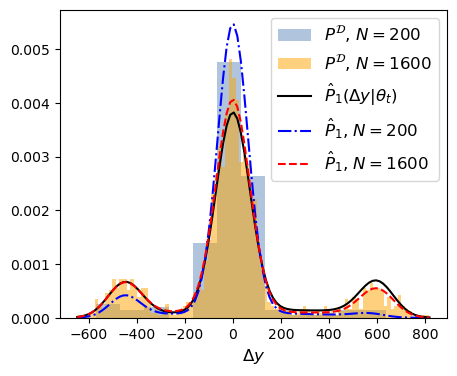

In [9]:
#Figure 3 panel D
eval_points = np.linspace(np.min(delta_y), np.max(delta_y), 100)

nbins = min(int(delta_y.shape[0]/10), 100)

plt.figure(figsize=(5,4))
plt.hist(delta_y[:200], bins=nbins//8, alpha=1.0, density=True, color='lightsteelblue', label=r'$P^{\mathcal{D}}$, $N=200$')
plt.hist(delta_y, bins=nbins, alpha=0.5, density=True, color='orange', label=r'$P^{\mathcal{D}}$, $N=1600$')
if theta_true is not None:
    approx_pdf_true = approx_pdf_theta(theta_true, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, approx_pdf_true, color='black', label=str(r'$\hat P_1(\Delta y|\theta_t)$'))
if log_pi is not None:
    modes_theta_comp = theta_all[:, np.nanargmax(log_pi)]
    approx_pdf_comp = approx_pdf_theta(modes_theta_comp, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, approx_pdf_comp, '-.', color='blue', label=str(r'$\hat P_1$, $N=200$'))
    modes_theta_comp_more = theta_all_more[:, np.nanargmax(log_pi_more)]
    approx_pdf_comp_more = approx_pdf_theta(modes_theta_comp_more, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, approx_pdf_comp_more, '--', color='red', label=str(r'$\hat P_1$, $N=1600$'))
plt.legend(fontsize=12)
plt.xlabel(r'$\Delta y$', fontsize=12)
plt.savefig("compare_best_fit_compared_to_data.png", format="png", dpi=1200, bbox_inches="tight")

In [10]:
#define points for which we need the PDF approximation  
minmax = np.arange(-809, 922, 5)
X, Y = np.meshgrid(minmax, minmax)

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res = np.array([[np.prod(approx_pdf_track_up_to_1_switch([V_F, V_B, 0],
                                                                          Lambda,
                                                                          P, sigma,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

V_best, Lambda_best, P_best, sigma_best = get_parameters(theta_best)

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res_best = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V_best,
                                                                                 Lambda_best,
                                                                          P_best, sigma_best,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])


V_best_more, Lambda_best_more, P_best_more, sigma_best_more = get_parameters(theta_best_more)

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res_best_more = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V_best_more,
                                                                                 Lambda_best_more,
                                                                          P_best_more, sigma_best_more,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

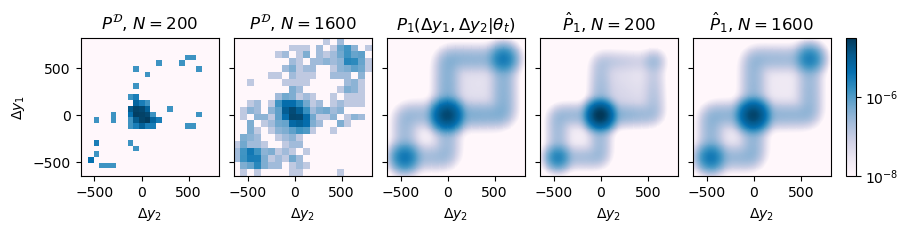

In [11]:
#Figure 3 panel E
fig = plt.figure(figsize=(10,2))
ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)

ax[0].hist2d(delta_y[1:200], delta_y[0:200-1], density=True, bins=20,
           norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)), cmap='PuBu')
ax[0].set_title(r'$P^{\mathcal{D}}$, $N=200$', fontsize=12)
ax[0].set_xlabel(r'$\Delta y_2$', fontsize=10)
ax[0].set_ylabel(r'$\Delta y_1$', fontsize=10)

ax[1].hist2d(delta_y[1:], delta_y[0:-1], density=True, bins=20,
           norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)), cmap='PuBu')
ax[1].set_title(r'$P^{\mathcal{D}}$, $N=1600$', fontsize=12)
ax[1].set_xlabel(r'$\Delta y_2$', fontsize=10)

cmap = mpl.colormaps['PuBu']
# Take colors at regular intervals spanning the colormap.
colors_vec = cmap(np.linspace(0, 1, 400))
ax[0].set_facecolor(colors_vec[0])
ax[1].set_facecolor(colors_vec[0])

ax[2].pcolor(Y, X, approx_pdf_track_res.T,
             norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)), cmap='PuBu')
ax[2].set_title(r'$P_1(\Delta y_1, \Delta y_2| \theta_t)$', fontsize=12)
ax[2].set_xlabel(r'$\Delta y_2$', fontsize=10)

pcm = ax[3].pcolor(Y, X, approx_pdf_track_res_best.T,
                   norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)), cmap='PuBu')
ax[3].set_title(r'$\hat P_1$, $N=200$', fontsize=12)
ax[3].set_xlabel(r'$\Delta y_2$', fontsize=10)

pcm = ax[4].pcolor(Y, X, approx_pdf_track_res_best_more.T,
                   norm=colors.LogNorm(vmin=10**(-8), vmax=10**(-4.5)), cmap='PuBu')
ax[4].set_title(r'$\hat P_1$, $N=1600$', fontsize=12)
ax[4].set_xlabel(r'$\Delta y_2$', fontsize=10)

ax[4].cax.colorbar(pcm)
ax[4].cax.toggle_label(True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("P_Deltay_1,Deltay_2_best_comp.png",
            format="png", bbox_inches="tight", dpi=1200)